# Word embeddings
### NLP 3rd homework
#### Fekete Bence

In [128]:
from google.colab import drive 

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
import nltk

import torch
from torch import nn
from torchsummary import summary

import numpy as np
import pandas as pd

import os
import re
import itertools

import time
import calendar

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
def print_progress(i, data_len, step_size):
    if i == 0:
        print('Processing started')
    elif i == data_len - 1:
        print('Finished processing %s datapoints' % str(i + 1))
    elif i % step_size == 0:
        print("Processed %d datapoints" % i)

# Define parameters + CUDA setup

In [4]:
BATCH_SIZE = 100

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
!nvidia-smi

# Get the data

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [190]:
!ls -lh '/content/drive/MyDrive/university/msc/nlp/word_embeddings/data'

total 11M
-rw------- 1 root root 165K Jun  3 01:27 ADollsHouseThePlay.txt
-rw------- 1 root root 171K Jun  3 01:25 AlicesAdventuresInWonderland.txt
-rw------- 1 root root  39K Jun  3 01:22 AModestProposal.txt
-rw------- 1 root root 128K Jun  3 01:22 Anthem.txt
-rw------- 1 root root 789K Jun  3 01:25 ATaleOfTwoCities.txt
-rw------- 1 root root 861K Jun  3 01:23 Drakula.txt
-rw------- 1 root root 439K Jun  3 00:54 frankenstein.txt
-rw------- 1 root root 1.1M Jun  3 01:17 greatExpectations.txt
-rw------- 1 root root 547K Jun  3 01:21 grimmsFairyTales.txt
-rw------- 1 root root 1.1M Jun  3 01:24 JaneEyreAnAutobiography.txt
-rw------- 1 root root 139K Jun  3 01:27 Metamorphosis.txt
-rw------- 1 root root 1.3M Jun  3 01:26 MobyDick.txt
-rw------- 1 root root 781K Jun  3 00:55 prideandprejudice.txt
-rw------- 1 root root 594K Jun  2 20:13 sherlock.txt
-rw------- 1 root root 597K Jun  3 01:20 theAdventuresOfHuckleberryFinn.txt
-rw------- 1 root root 424K Jun  3 01:22 theAdventuresOfTomSawyer.

In [191]:
data_path = '/content/drive/MyDrive/university/msc/nlp/word_embeddings/data/'
filenames = os.listdir(data_path)

corpus = []

for filename in filenames:
    with open(data_path + filename, 'r') as reader:
        for line in reader.readlines():
            corpus.append(line)

print("Read data from %d files, corpus length: %d" % (len(filenames), len(corpus)))

Read data from 23 files, corpus length: 218293


# Basic preprocessing

In [192]:
def tokenize(text):
    tokens = [x for x in nltk.word_tokenize(text.lower()) if x.isalpha()]
    tokens = [tkn for tkn in tokens if tkn not in nltk.corpus.stopwords.words('english')]
    return tokens

In [193]:
def get_tokens_from_corpus(corpus, show_progress=True, progress_step_size=2e4):
    corpus_tokens = []
    i = 0
    for elem in corpus:
        corpus_tokens.extend(tokenize(elem))

        if show_progress:
            print_progress(i, len(corpus), progress_step_size)
        i+=1

    return corpus_tokens

corpus_tokens = get_tokens_from_corpus(corpus)

Processing started
Processed 20000 datapoints
Processed 40000 datapoints
Processed 60000 datapoints
Processed 80000 datapoints
Processed 100000 datapoints
Processed 120000 datapoints
Processed 140000 datapoints
Processed 160000 datapoints
Processed 180000 datapoints
Processed 200000 datapoints
Finished processing 218293 datapoints


In [194]:
print("Number of tokens: %d" % len(corpus_tokens))

Number of tokens: 883752


# Building vocabulary and word pairs

In [195]:
def build_vocab_from_tokens(tokens, show_progress=True, progress_step_size=1e5):
    vocabulary = {}
    for i, token in enumerate(tokens):
        vocabulary[token] = i

    if show_progress:
        print_progress(i, len(tokens), progress_step_size)

    # resetting the indices (values) in the vocabulary
    i = 0
    for key, val in vocabulary.items():
        vocabulary[key] = i
        i += 1

    return vocabulary

# build_vocab_from_tokens(corpus_tokens)

In [196]:
vocab = build_vocab_from_tokens(corpus_tokens)

Finished processing 883752 datapoints


In [197]:
len(vocab) # number of unique words in the corpus

34364

In [198]:
def build_pairs_from_neighbourhoods(corpus_tokens, window = 2, show_progress=True, progress_step_size=25000):
    word_idx_pairs = []

    i = 0
    for i, token in enumerate(corpus_tokens):
        if window == 0:
            raise ValueError("Invalid window size 0, window size should be >= 1")
        if i == 0:
            group = corpus_tokens[i:i+window+1]
        elif i < window:
            group = corpus_tokens[window-i-1:i+window+1]
        else:
            group = corpus_tokens[i-window:i+window+1]

        pairs = list(itertools.combinations(group, 2))
        
        # add the index pairs
        for pair in pairs:
            word_idx_pairs.append((vocab[pair[0]], vocab[pair[1]]))
        
        if show_progress:
            print_progress(i, len(corpus_tokens), progress_step_size)
        i+=1

    # delete the duplicates
    word_idx_pairs = set(word_idx_pairs)

    word_idx_pairs = sorted(word_idx_pairs)
    
    word_idx_pairs_list = []
    for elem in word_idx_pairs:
        word_idx_pairs_list.append((elem[0], elem[1]))

    word_idx_pairs_list = np.array(word_idx_pairs_list)

    return word_idx_pairs_list

In [199]:
def get_one_hot_vector(word_idx, vocab_size, label=False):
    if label == False:
        idx = 0
    else:
        idx = 1

    vec = torch.zeros((BATCH_SIZE, vocab_size), device=device).float()

    for i in range(BATCH_SIZE):
        vec[i][word_idx[i][idx]] = 1.0

    return vec

In [200]:
data = build_pairs_from_neighbourhoods(corpus_tokens, window=3)
print("Number of pairs: %d" % len(data))

Processing started
Processed 25000 datapoints
Processed 50000 datapoints
Processed 75000 datapoints
Processed 100000 datapoints
Processed 125000 datapoints
Processed 150000 datapoints
Processed 175000 datapoints
Processed 200000 datapoints
Processed 225000 datapoints
Processed 250000 datapoints
Processed 275000 datapoints
Processed 300000 datapoints
Processed 325000 datapoints
Processed 350000 datapoints
Processed 375000 datapoints
Processed 400000 datapoints
Processed 425000 datapoints
Processed 450000 datapoints
Processed 475000 datapoints
Processed 500000 datapoints
Processed 525000 datapoints
Processed 550000 datapoints
Processed 575000 datapoints
Processed 600000 datapoints
Processed 625000 datapoints
Processed 650000 datapoints
Processed 675000 datapoints
Processed 700000 datapoints
Processed 725000 datapoints
Processed 750000 datapoints
Processed 775000 datapoints
Processed 800000 datapoints
Processed 825000 datapoints
Processed 850000 datapoints
Processed 875000 datapoints
Fini

In [201]:
data.shape

(3238470, 2)

In [202]:
data_loader = torch.utils.data.DataLoader(
    data, shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=os.cpu_count(),
    drop_last=True
)

# Skipgram model

In [203]:
embedding_dim = 100
lr = 2e-1
vocab_size = len(vocab)

skipgram = torch.nn.Sequential(
    nn.Linear(in_features=vocab_size, out_features=embedding_dim, bias=False),
    nn.Linear(in_features=embedding_dim, out_features=vocab_size, bias=False),
    nn.LogSoftmax(dim=1)
)

skipgram = skipgram.to(device)

optimizer = torch.optim.SGD(
    skipgram.parameters(),
    lr = lr
)

loss_fn = nn.NLLLoss()

losses = []

In [204]:
summary(skipgram, (100, vocab_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 100, 100]       3,436,400
            Linear-2           [-1, 100, 34364]       3,436,400
        LogSoftmax-3           [-1, 100, 34364]               0
Total params: 6,872,800
Trainable params: 6,872,800
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 13.11
Forward/backward pass size (MB): 52.51
Params size (MB): 26.22
Estimated Total Size (MB): 91.84
----------------------------------------------------------------


In [21]:
!ls /content/drive/MyDrive/university/msc/nlp/word_embeddings/
# !mkdir /content/drive/MyDrive/university/msc/nlp/word_embeddings/checkpoints

checkpoints  data  traffic_annotation  word_embeddings_old.ipynb


In [24]:
### Training parameters ###

model_name='skipgram'
epochs = 10

print_progress_step_size = 1e3

cp_interval = 1
cp_dir = '/content/drive/MyDrive/university/msc/nlp/word_embeddings/checkpoints/'

############################


for epoch in range(epochs):
    i = 0

    for batch_idx, data in enumerate(data_loader):
        y_hat = skipgram(get_one_hot_vector(data, vocab_size))
        y = torch.tensor([x[1] for x in data], device=device)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if i % print_progress_step_size == 0:
            print(
                'epoch {}: [{}/{} ({:.0f}%)]  --  loss = {}'.format(
                    epoch,
                    batch_idx * len(data),
                    len(data_loader.dataset),
                    100.0 * batch_idx / len(data_loader),
                    loss.item()
                )
            )

        i += 1

    if epoch % cp_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': skipgram.state_dict(),
            'loss': loss.item()
        },cp_dir + 'checkpoint_' + model_name + "_" + str(int(calendar.timegm(time.gmtime()))) + ".pt")
        print('Checkpoint saved.')
    print()

epoch 0: [0/3238470 (0%)]  --  loss = 10.444458961486816
epoch 0: [100000/3238470 (3%)]  --  loss = 10.445087432861328
epoch 0: [200000/3238470 (6%)]  --  loss = 10.444696426391602
epoch 0: [300000/3238470 (9%)]  --  loss = 10.444668769836426
epoch 0: [400000/3238470 (12%)]  --  loss = 10.444568634033203
epoch 0: [500000/3238470 (15%)]  --  loss = 10.444741249084473
epoch 0: [600000/3238470 (19%)]  --  loss = 10.444679260253906
epoch 0: [700000/3238470 (22%)]  --  loss = 10.444710731506348
epoch 0: [800000/3238470 (25%)]  --  loss = 10.444754600524902
epoch 0: [900000/3238470 (28%)]  --  loss = 10.445025444030762
epoch 0: [1000000/3238470 (31%)]  --  loss = 10.444369316101074
epoch 0: [1100000/3238470 (34%)]  --  loss = 10.445101737976074
epoch 0: [1200000/3238470 (37%)]  --  loss = 10.444665908813477
epoch 0: [1300000/3238470 (40%)]  --  loss = 10.444794654846191
epoch 0: [1400000/3238470 (43%)]  --  loss = 10.444684982299805
epoch 0: [1500000/3238470 (46%)]  --  loss = 10.44501686096

In [25]:
# load previously trained model
weights_path = 'drive/MyDrive/university/msc/nlp/word_embeddings/checkpoints/checkpoint_skipgram_10epochs.pt'
weights = torch.load(weights_path, map_location=torch.device('cpu'))
weights = weights['model_state_dict']
skipgram.load_state_dict(state_dict=weights)

<All keys matched successfully>

In [35]:
weights['0.weight']

tensor([[ 0.0931,  0.0809,  0.1805,  ...,  0.0395,  0.0151,  0.0331],
        [ 0.0212,  0.0232,  0.1074,  ...,  0.0248, -0.0008,  0.0071],
        [-0.0788, -0.0952, -0.1745,  ..., -0.0333, -0.0116, -0.0361],
        ...,
        [ 0.0220,  0.0147,  0.0586,  ...,  0.0087,  0.0114,  0.0162],
        [-0.0086, -0.0120,  0.0170,  ...,  0.0075,  0.0093, -0.0084],
        [ 0.1506,  0.1584,  0.1767,  ...,  0.0423,  0.0158,  0.0392]])

In [36]:
skipgram[0].weight

Parameter containing:
tensor([[ 0.0931,  0.0809,  0.1805,  ...,  0.0395,  0.0151,  0.0331],
        [ 0.0212,  0.0232,  0.1074,  ...,  0.0248, -0.0008,  0.0071],
        [-0.0788, -0.0952, -0.1745,  ..., -0.0333, -0.0116, -0.0361],
        ...,
        [ 0.0220,  0.0147,  0.0586,  ...,  0.0087,  0.0114,  0.0162],
        [-0.0086, -0.0120,  0.0170,  ...,  0.0075,  0.0093, -0.0084],
        [ 0.1506,  0.1584,  0.1767,  ...,  0.0423,  0.0158,  0.0392]],
       requires_grad=True)

In [37]:
# get the weights
weights = skipgram[0].weight

embedding_dict = {}
for w in vocab:
    embedding_dict[w] = weights[:, vocab[w]].cpu().detach()

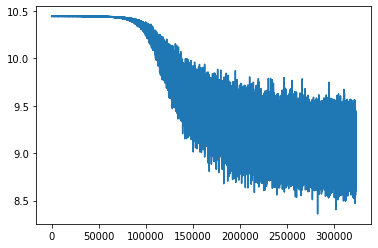

In [26]:
plt.plot(losses, label='Loss')

# Processing Wordsim-353

In [207]:
wordsim_filename = 'wordsim353/wordsim-353-combined.csv'
print("Reading %s \n   from %s" % (wordsim_filename, data_path))

df = pd.read_csv(data_path + wordsim_filename)

# rename the columns
df = df.rename(
    columns={
        'Word 1': 'word1',
        'Word 2': 'word2',
        'Human (mean)': 'mean'
        }
    )

# normalize mean values to (0, 1)
df['mean'] = df['mean'] / 10
df

Reading wordsim353/wordsim-353-combined.csv 
   from /content/drive/MyDrive/university/msc/nlp/word_embeddings/data/


,word1,word2,mean
0,love,sex,0.677
1,tiger,cat,0.735
2,tiger,tiger,1.000
3,book,paper,0.746
4,computer,keyboard,0.762
...,...,...,...
348,shower,flood,0.603
349,weather,forecast,0.834
350,disaster,area,0.625
351,governor,office,0.634


In [208]:
cos_sim = nn.CosineSimilarity(dim = 0)
missing_count = 0
model_sim = []
human_sim = []

pairs = []

for i, row in df.iterrows():
    if (row['word1'] not in vocab) or (row['word2'] not in vocab):
        missing_count+=1
    else:
        pairs.append((row['word1'], row['word2']))
        human_sim.append(row['mean'])
        
        w1 = embedding_dict[row['word1']]
        w2 = embedding_dict[row['word2']]
        sim_score = max(torch.zeros(1), cos_sim(w1, w2))
        model_sim.append(sim_score.item())

print('Number of missing pairs = %d' % missing_count)
print('Sanity check: %d [missing] + %d [found] = %d [wordsim_length]' % (missing_count, len(human_sim), missing_count + len(human_sim)))

Number of missing pairs = 89
Sanity check: 89 [missing] + 264 [found] = 353 [wordsim_length]


In [209]:
df_human_skip = pd.DataFrame(columns=['w1', 'w2', 'skipgram_sim', 'human_sim', 'abs_diff', 'sq_err'])

for i in range(len(model_sim)):

    sq_err = (human_sim[i] - model_sim[i]) ** 2
    row = [pairs[i][0], pairs[i][1], model_sim[i], human_sim[i], abs(model_sim[i] - human_sim[i]), sq_err]
    # print(row)
    df_human_skip.loc[i] = row

    # print('[{}, {}] \tmodel_sim = {:.3f}\t human_sim =  {:.3f} \tabs_diff={:.3f}\t sq_err={:.3f}'.format(
    #     pairs[i][0],
    #     pairs[i][1],
    #     model_sim[i],
    #     human_sim[i],
    #     abs(model_sim[i] - human_sim[i]),
    #     sq_err
    # ))

df_human_skip

,w1,w2,skipgram_sim,human_sim,abs_diff,sq_err
0,love,sex,0.747717,0.677,0.070717,0.005001
1,tiger,cat,0.906865,0.735,0.171865,0.029538
2,tiger,tiger,1.000000,1.000,0.000000,0.000000
3,book,paper,0.953872,0.746,0.207872,0.043211
4,plane,car,0.944376,0.577,0.367376,0.134965
...,...,...,...,...,...,...
259,shower,flood,0.987980,0.603,0.384980,0.148209
260,weather,forecast,0.916578,0.834,0.082578,0.006819
261,disaster,area,0.989848,0.625,0.364848,0.133114
262,governor,office,0.961712,0.634,0.327712,0.107395


## MSE loss: WordSim-353 vs. Skipgram model

In [210]:
# Calculate MSE loss between human similarities and model similarities
loss_fnc = torch.nn.MSELoss()

human_sim_tnsr = torch.tensor(human_sim)
model_sim_tnsr = torch.tensor(model_sim)

mse_loss_wordsim_skipgram = loss_fnc(human_sim_tnsr, model_sim_tnsr)
print("MSE loss WordSim353 vs Skipgram = %.8f" % mse_loss_wordsim_skipgram.item())

MSE loss WordSim353 vs Skipgram = 0.16169895


# Bag of Words model

In [211]:
bow = []

w1 = [w[0] for w in pairs]
w2 = [w[1] for w in pairs]

sim_list = w1 + w2
sim_list = set(sim_list)
print("Length of sim_list = %d" % len(sim_list))

for word in corpus_tokens:
    if word in sim_list:
        bow.append(word)
print("Length of BoW = %d" % len(bow))

Length of sim_list = 338
Length of BoW = 50616


In [212]:
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()

count_mtrx = vectorizer.fit_transform(bow)
count_arr = count_mtrx.toarray()
print("Created count array with shape: {}".format(count_arr.shape))

Created count array with shape: (50616, 338)


In [213]:
missing_count = 0
bow_sim = []
bow_words = vectorizer.get_feature_names()

for i, row in df.iterrows():
    if (row['word1'] not in vocab) or (row['word2'] not in vocab):
        missing_count+=1
    else:
        idx1 = [i for i, w in enumerate(bow_words) if w == row['word1']][0]
        idx2 = [i for i, w in enumerate(bow_words) if w == row['word2']][0]

        in1 = count_arr[:, idx1]
        in2 = count_arr[:, idx2]

        bow_sim.append(
            distance.cosine(in1, in2)
        )

print('Number of missing pairs = %d' % missing_count)

Number of missing pairs = 89


In [214]:
df_bow_skip = pd.DataFrame(columns=['w1', 'w2', 'skipgram_sim', 'bow_sim', 'abs_diff'])

for i in range(len(model_sim)):

    row = [pairs[i][0], pairs[i][1], model_sim[i], bow_sim[i], abs(model_sim[i] - bow_sim[i])]
    # print(row)
    
    df_bow_skip.loc[i] = row
    # print('[{}, {}] \tmodel_sim = {:.3f}\t bow_sim =  {:.3f} \tabs_diff={:.3f}'.format(
    #     pairs[i][0],
    #     pairs[i][1],
    #     model_sim[i],
    #     bow_sim[i],
    #     abs(model_sim[i] - bow_sim[i])
    # ))

df_bow_skip

,w1,w2,skipgram_sim,bow_sim,abs_diff
0,love,sex,0.747717,1.0,0.252283
1,tiger,cat,0.906865,1.0,0.093135
2,tiger,tiger,1.000000,0.0,1.000000
3,book,paper,0.953872,1.0,0.046128
4,plane,car,0.944376,1.0,0.055624
...,...,...,...,...,...
259,shower,flood,0.987980,1.0,0.012020
260,weather,forecast,0.916578,1.0,0.083422
261,disaster,area,0.989848,1.0,0.010152
262,governor,office,0.961712,1.0,0.038288


## MSE loss: BoW vs Skipgram

In [215]:
# Calculate MSE loss between BoW similarities and model similarities
loss_fnc = torch.nn.MSELoss()

bow_sim_tnsr = torch.tensor(bow_sims)
model_sim_tnsr = torch.tensor(model_sim)

mse_loss_bow_skipgram = loss_fnc(bow_sim_tnsr, model_sim_tnsr)
print("MSE loss BoW vs Skipgram = %.8f" % mse_loss_bow_skipgram.item())

MSE loss BoW vs Skipgram = 0.02422805
